<a href="https://colab.research.google.com/github/GilbertAshivaka/Autograd/blob/main/MicroGrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

In [3]:
def f(x):
  return 3*x**2-4*x+5

In [4]:
f(3.0)

20.0

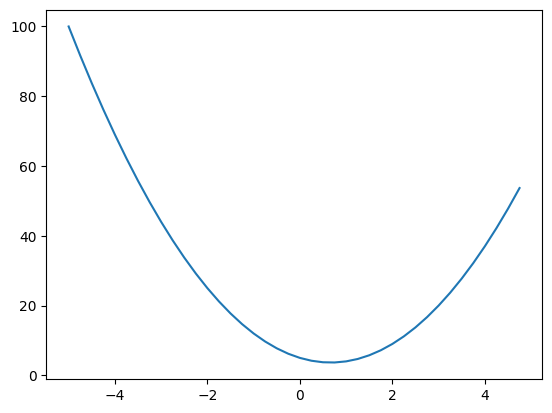

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

plt.plot(xs, ys)

In [6]:
h = 0.00000001
x = 2/3
(f(x+h)-f(x))/h

0.0

In [23]:
#a bit more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b +c
print(d)

4.0


In [4]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b +c
c += h
d2 = a*b +c

print("d1", d1)
print("d2", d2)
print("Slope", (d2-d1)/h)


d1 4.0
d2 4.0001
Slope 0.9999999999976694


In [3]:
class Value:
  def __init__(self, data, _children=(), _op='', label = ''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data = {self.data})"

  def __radd__(self, other):
    return self + other

  def __add__(self, other):
    #to make it possible to add Values that aren't of the Value class
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0*out.grad
      other.grad += 1.0* out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data*out.grad
      other.grad += self.data*out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), 'only supporting int/float for now'
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad = other*(self.data**(other-1))*out.grad
    out._backward = _backward
    return out

  #to make it possible to multiply 2 * a
  def __rmul__(self, other):
    return self*other

  def __truediv__(self, other):
    return self*(other**-1)

  #implementing subtraction
  def __neg__(self):
    return self* -1

  def __sub__(self, other): #self - other
    return self+ (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2)  * out.grad

    out._backward = _backward

    return out

  #implementing the exp function
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')
    def _backward():
      self.grad = out.data*out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

# a+b python calls this method(a.__add__b)
# (a.__mul__(b)).__add__(c)

In [3]:
#Could no be able to add attributes that are of the Value class and those that aren't
a = Value(2.0)
b = Value(4.0)
c = a-b
c

Value(data = -2.0)

In [2]:
from graphviz import Digraph
def trace(root):
  #builds all sets of nodes and edges in the graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
    for child in v._prev:
      edges.add((child, v))
      build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format= 'svg', graph_attr= {'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    #for any value in the graph, create a rectangular 'record'node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')

    if n._op:
      #if this value is a result of some operation create an _op node for it
      dot.node(name = uid + n._op, label = n._op)
      #and connect to this node
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    #connect n1 to the _op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot

In [21]:
#Inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights w1 and w2
w1 = Value(-3.0, label = 'x2')
w2 = Value(1.0, label = 'w2')

#bias of the neuron
b = Value(6.8813735870195432, label = 'b')

#x1w1x2w2+b (implemented in steps to create nodes)
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

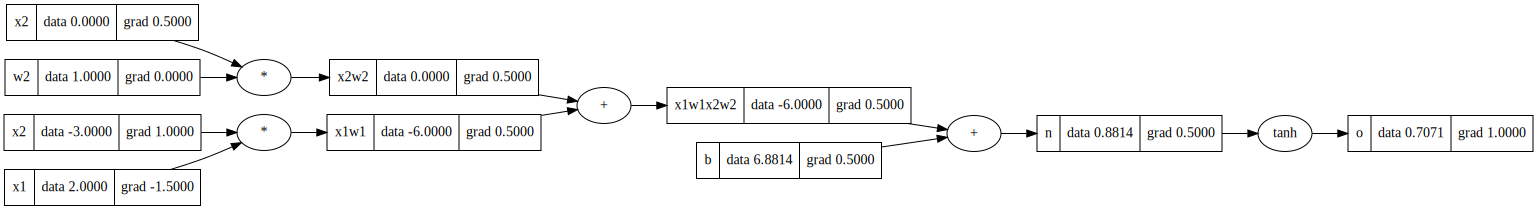

In [20]:
draw_dot(o)

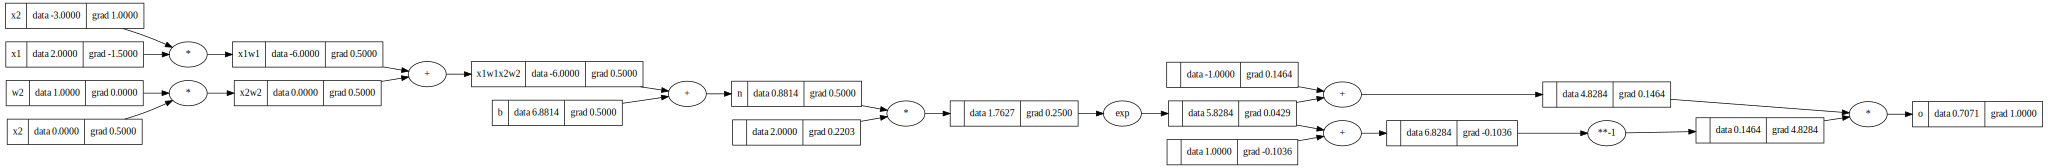

In [23]:
#Inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights w1 and w2
w1 = Value(-3.0, label = 'x2')
w2 = Value(1.0, label = 'w2')

#bias of the neuron
b = Value(6.8813735870195432, label = 'b')

#x1w1x2w2+b (implemented in steps to create nodes)
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'

#------implementing tanh in another way
e = (2*n).exp()
o = (e - 1)/ (e + 1)
#------
o.label = 'o'
o.backward()
draw_dot(o)

In [26]:
import torch

In [31]:
#implementing all that using pytorch
x1 = torch.Tensor([2.0]).double();                x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();                x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();               w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();                w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();   b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print('--------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
--------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [334]:
class Neuron:
  def __init__(self, nin): #nin => number of inputs
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))
  def __call__(self, x):
    #w*x + b...doing the actual forward pass
    act = sum((wi*xi for wi, xi in zip( self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) ==1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    #can be implemented as...
    # params = []
    # for neuron in self.neurons:
    #   ps = neuron.parameters()
    #   params.extend(ps)
    # return params

#creating a multilayer perceptron
class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [335]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data = -0.4850130204618756)

In [336]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] #desired targets

In [337]:
#full training loop
for k in range(20):
  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))


  #zero grad before backward pass
  # for p in n.parameters():
  #   p.grad = 0.0

  #backward pass
  loss.backward()

  #update
  for p in n.parameters():
    p.data = -0.5*p.grad
  print(k, loss.data)

0 5.97949169948352
1 2.9511538730228333
2 0.001089694089109466
3 0.0009714020913781109
4 0.0008765590856143559
5 0.0007987534748694664
6 0.0007337324664289277
7 0.0006785592478232587
8 0.0006311380077502415
9 0.000589931611329251
10 0.0005537862623086492
11 0.0005218185261451575
12 0.0004933402148486037
13 0.0004678070744169845
14 0.00044478289442836466
15 0.00042391387699469447
16 0.00040490999131422744
17 0.00038753118420527125
18 0.0003715770293960301
19 0.0003568788529797331


In [260]:
n.parameters()

[Value(data = 0.19264166877678573),
 Value(data = 0.6936237590725827),
 Value(data = -0.7248633538089975),
 Value(data = -1.0863692094316069),
 Value(data = -0.2367579396189537),
 Value(data = 1.195376063428734),
 Value(data = 0.17038811574389856),
 Value(data = -0.14196718317134122),
 Value(data = 0.5929175911483602),
 Value(data = 0.605618764705596),
 Value(data = -0.2708858691041868),
 Value(data = -0.4193260965278078),
 Value(data = 0.2517507387111367),
 Value(data = 0.7725446978503419),
 Value(data = -1.5914369858906579),
 Value(data = -0.016254881500765248),
 Value(data = -0.7304053574541503),
 Value(data = -0.5591831793934561),
 Value(data = 0.05233705498131583),
 Value(data = -1.037650275053107),
 Value(data = -0.13916652956457104),
 Value(data = -1.1811944231242901),
 Value(data = -0.43734651435662003),
 Value(data = 0.12793829271136833),
 Value(data = -0.12378988143696143),
 Value(data = 0.3585209968419801),
 Value(data = 0.08295043577624114),
 Value(data = -0.019220070946106

In [199]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt , yout in zip(ys, ypred)])
loss

Value(data = 2.5486004106635027)

In [258]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt , yout in zip(ys, ypred)])
loss

Value(data = 2.6785349886759212e-05)

In [256]:
loss.backward()

In [257]:
for p in n.parameters():
  p.data += -0.01* p.grad

In [338]:
ypred

[Value(data = 0.987022705291037),
 Value(data = -0.9999812027377271),
 Value(data = -0.9998874204542241),
 Value(data = 0.9862720850991399)]

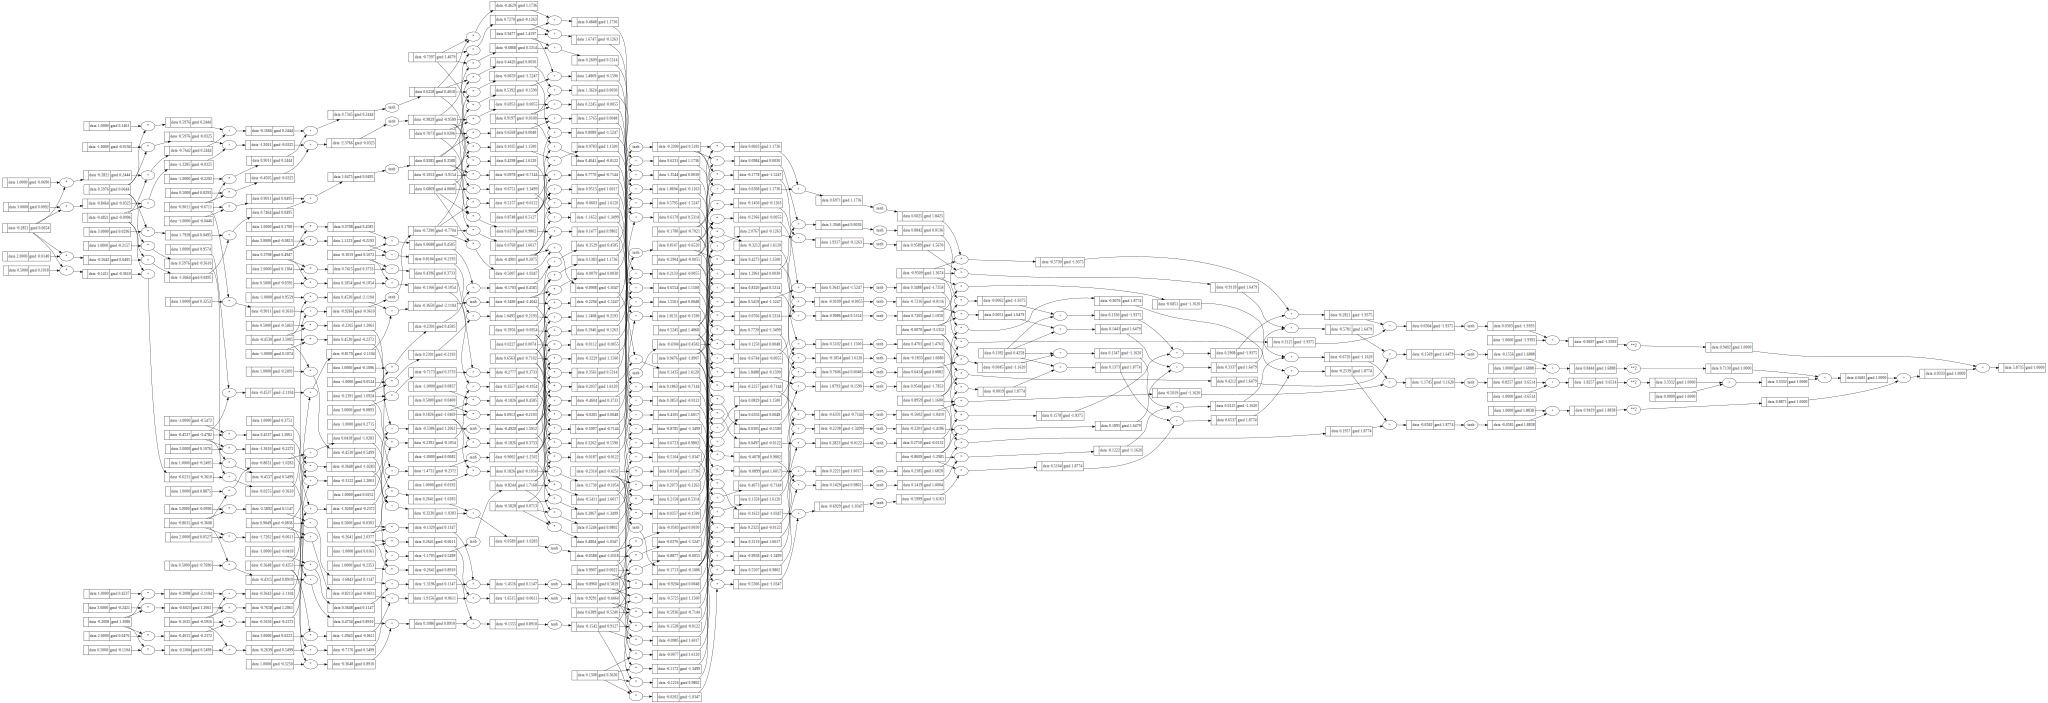

In [57]:
draw_dot(loss)

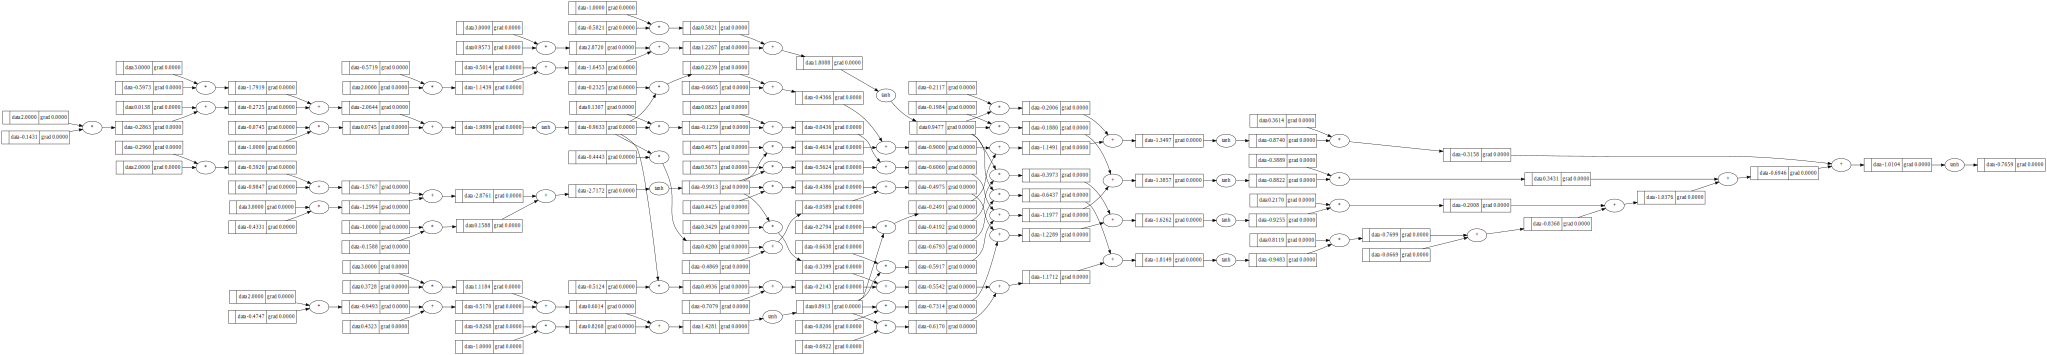

In [21]:
draw_dot(n(x))

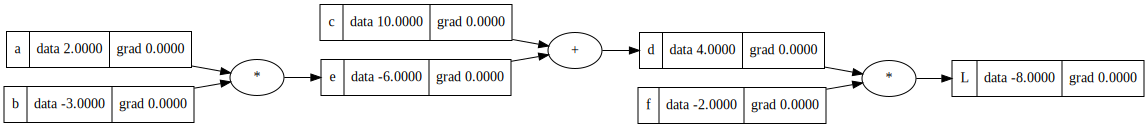

In [4]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'
draw_dot(L)

In [10]:
a.data += 0.01*a.grad
b.data += 0.01*b.grad
c.data += 0.01*c.grad
f.data += 0.01*f.grad

e = a*b
d = e + c
L = d*f

print(L.data)

-7.286496


L = d*f
dL/dd = ? >>>f      
derivatives from first principles expression     
(f(x+h) - f(x))/h     
this becomes                     
((d+h)*f) - (d*f)       
(d*f + h*f - d*f)/h   
h*f/h -> f

Findind dd/dc        
dd/dc ? => 1.0     
d = c + e     
dd/dc -> 1.0  
symetrically....
dd/de = 1.0

((c+h+e) - (c+e))/h   
(c+h+e-c-e)/h => h/h = 1

WE WANT:    
dL/dc     
WE KNOW:      
dL/dd, and dd/dc   
so dL/dc will be: (dL/dd)*(dd/dc) ==> -2,0 X 1.0 = -2.0

dL/de = -2
e = a*b
de/da = ? =>>b
dL/da = (dL/de)*(de/da)


In [8]:
b.grad = -4
a.grad = 6.0
c.grad = -2.0
e.grad = -2.0
d.grad = -2.0
f.grad = 4.0
L.grad = 1.0

In [ ]:
def lol():
  h = 0.001

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  c = Value(10.0, label = 'c')
  e = a*b; e.label = 'e'
  d = e+c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d*f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label = 'b')
  b.data += h
  c = Value(10.0, label = 'c')
  e = a*b; e.label = 'e'
  d = e+c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d*f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

-3.9999999999995595


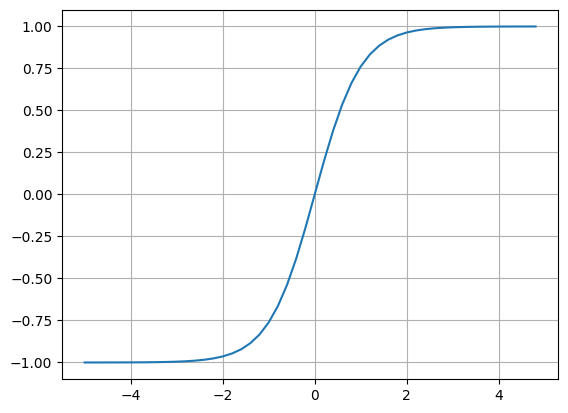

In [22]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [7]:
o.backward()

In [15]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

for node in reversed(topo):
  node._backward()

In [12]:
o.grad = 1.0

In [18]:
o._backward()

In [20]:
n.backward()

In [22]:
b._backward()

In [26]:
x1w1x2w2.backward()

In [29]:
x1w1._backward()
x2w2._backward()

o = tanh(n)    
do/dn = 1 - tanh^2 (n)    
and tanh(n) = o    
therefore:    
do/dn = 1 - o^2


In [16]:
print(o.data)
1 - o.data**2

0.7071067811865476


0.4999999999999999

In [23]:
x2.grad = w2.data*x2w2.grad
w2.grad = x2.data*x2w2.grad
x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad

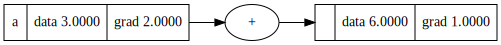

In [15]:
#these gradients are overwritten because we do not accumulate them. The soulution is to accumulate them using +=
a = Value(3.0, label = 'a')
b = a + a; label = 'b'
b.backward()
draw_dot(b)

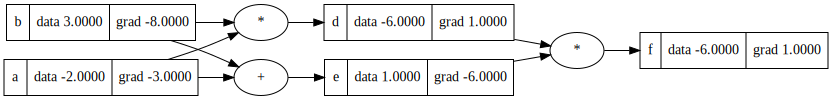

In [16]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a * b; d.label= 'd'
e = a + b; e.label = 'e'
f = d*e; f.label = 'f'
f.backward()
draw_dot(f)